In [1]:
import os; print(os.getcwd())
import socket; print(socket.gethostname())
import sys; print(sys.executable)

c:\Users\lizau\Desktop\walker_tracker
D12-LUlcakar-NB
c:\Users\lizau\conda\envs\ImageAligner\python.exe


In [2]:
import numpy as np
from scipy.stats import multivariate_normal 
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt


In [3]:
def get_rot_matrix(ang_deg):
    """Returns a 2x2 rotation matrix, with angle given in deg"""
    theta = np.radians(ang_deg)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))
    return R

def get_cov_matrix_from_rot(s_x, s_y, rot_deg):
    rot_matrix = get_rot_matrix(rot_deg)
    principal = np.array([[s_x, 0],
                          [0,   s_y]])
    cov =  rot_matrix @ principal @ rot_matrix.T
    return cov

def cov_to_axes_and_rotation(cov, sorted=True):
    """"Takes a covariance matrix and returns the principle axes and a rotation"""
    (e1, e2), eigen_vec = np.linalg.eig(cov)
    V1,V2 = eigen_vec.T
    
    # Eigenvectors are assumed to be unit and orthogonal
    # print(np.linalg.norm(V1))
    e1 = np.real(e1) # sometimes tiny imaginary components are returned. 
    e2 = np.real(e2) # sometimes tiny imaginary components are returned. 
    if np.isclose(e1, e2):
        # the angle is not well defined
        theta = 0

    else:
        # Are eigenvectors always normalized? 
        theta = np.degrees(np.arctan2(V1[0], V1[1]))
    #if theta>90 and theta <180:
    #     theta = 180 - theta
    #print(theta)

    if sorted: #make sure e1 is always the largest
        if e2>e1:
            (e1, e2) = (e2, e1)
            theta = theta + 90

    return e1, e2, np.mod(theta, 360)

# Taken from Ljubetič, Recovering position-dependent diffusion from biased molecular dynamics simulations
# But does not work? Probably typed equation 17 incorrectly  
#def cov_to_axes_and_rotation(cov):
#    """"Takes a covariance matrix and returns the principle axes and a rotation"""
#    sxx = cov[0,0]
#    syy = cov[1,1]
#    sxy = cov[0,1]
#    assert(cov[0,1]==cov[1,0])
#    sqrt_part = np.sqrt(sxx*sxx + 4*sxy*sxy-2*sxx*syy + syy*syy)
#    s_nx = 0.5*(sxx + syy - sqrt_part)
#    s_ny = 0.5*(sxx + syy + sqrt_part)
#    alpha = np.arccos((sxx - np.sqrt( (sxx-syy)**2 + 4*sxy*sxy - syy))/np.sqrt(8*sxy*sxy-2*(sxx-syy)*(syy-sxx + np.sqrt( (sxx-syy)**2 + 4*sxy*sxy))))
#    alpha = np.degrees(alpha)
#    return(s_nx,s_ny,alpha)

def plot_gauss_2d(mean, cov):
    gauss2d = multivariate_normal(mean, cov)
    x, y = np.mgrid[-5:5:.1, -5:5:.1]
    pos = np.dstack((x, y))
    plt.contourf(x, y, gauss2d.pdf(pos))
    ax = plt.gca()
    ax.set_aspect('equal')

    (e1, e2), eigen_vec = np.linalg.eig(cov)
    V1,V2 = eigen_vec.T
    e1 = np.real(e1) # sometimes tiny imaginary components are returned. 
    e2 = np.real(e2) # sometimes tiny imaginary components are returned. 
    plt.quiver(mean[0], mean[1], V1[0], V1[1], color='red',   scale=1/e1*10)
    plt.quiver(mean[0], mean[1], 1, 0,         color='black', scale=1/e1*10)
    plt.quiver(mean[0], mean[1], V2[0], V2[1], color='blue',  scale=1/e2*10)
    #angle = vg.angle(np.array([1,0,0]), np.array([V1[0], V1[1], 0]))
    #plt.title(f'{angle}')
#plot fig

def plot_gauss_2d_interactive(u_x=0, u_y=0, s_x=1, s_y=3, rot_deg=0, do_print=False, sorted=True, plot_recovered=False):
    cov = get_cov_matrix_from_rot(s_x, s_y, rot_deg)
    #print (cov)

    (s_xn, s_yn, theta_deg) = cov_to_axes_and_rotation(cov, sorted=sorted)
    cov1 = get_cov_matrix_from_rot(s_xn, s_yn, theta_deg)
    if plot_recovered:
        plot_gauss_2d([u_x, u_y], cov1);
    else:
        plot_gauss_2d([u_x, u_y], cov);

    if do_print:
        print(f'u_x={u_x} u_y={u_y}, s_x={s_x}, s_y={s_y}, rot_deg={rot_deg}')
        print('')
        print('mean = np.', np.array_repr(np.array([u_x, u_y])))
        print('cov = np.', np.array_repr(np.array((cov))))
        print('')
        
        print(f'{s_xn=}, {s_yn=}, {theta_deg=} ')
        
        print('cov == cov1',np.isclose(cov, cov1))

panel = interactive(plot_gauss_2d_interactive,
         u_x=(-10,10,.1), u_y=(-10,10,.1), 
         s_x=(0.1, 10, 0.1), s_y=(0.1, 10, 0.1), rot_deg=(0,360,1))

panel



interactive(children=(FloatSlider(value=0.0, description='u_x', max=10.0, min=-10.0), FloatSlider(value=0.0, d…

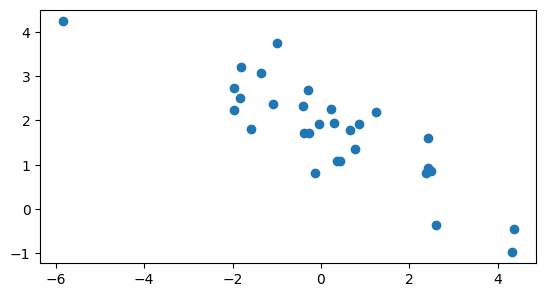

In [6]:
dataset = np.load('gauss2d.npy')
plt.scatter(dataset.T[0], dataset.T[1])
ax = plt.gca()
ax.set_aspect('equal')

In [ ]:
# plot theta vs recovered theta
thetas = np.linspace(0, 360, 100)
recoverd_thetas = np.zeros_like(thetas)
for n,theta in enumerate(thetas):
    recoverd_thetas[n] = cov_to_axes_and_rotation(get_cov_matrix_from_rot(2,1,theta), sorted=False)[2]


plt.scatter(thetas, recoverd_thetas)

In [19]:
cov = [[0.672,-0.107],[-0.107,0.51]]

print(cov_to_axes_and_rotation(cov, sorted=True))

(0.7252013412749665, 0.4567986587250336, 333.5630309341372)
